In [1]:
%config Completer.use_jedi = False
import sys
import warnings
warnings.filterwarnings('ignore')

import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

MEMORY = 4*1024

gpus = tf.config.list_physical_devices('GPU')
try:
    tf.config.set_logical_device_configuration(gpus[0],
                                              [tf.config.LogicalDeviceConfiguration(memory_limit=MEMORY)])
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
except RuntimeError as e:        
    # Memory growth must be set before GPUs have been initialized
    print(e) 
    
import pathlib
import pickle
from pathlib import Path
sys.path.append(f"{Path.home()}/morpho_repo")
sys.path.append(f"{Path.home()}/morpho_repo/turing_codebase")
from turing.utils import *
from turing.tf_utils import *
import turing.pinns as tu
from turing.loss_functions import *

1 Physical GPUs, 1 Logical GPUs


In [2]:
from local_utils import *

# Load the parameters

In [3]:
with open('turing_parameters.npy', 'rb') as f:
    turing_parameters = np.load(f)

with open('./outputs/indices.npy', 'rb') as f:
    indices = np.load(f)
    

In [4]:
def load_dataset(index):
    with open(f"./outputs/parameters_100_{index}.npy", "rb") as f:
        params = np.load(f)
    (n_val, 
     b_A_val, mu_A_val, V_A_val, K_AA_val, K_AB_val, K_AC_val,
     b_B_val, mu_B_val, V_B_val, K_BA_val, K_BC_val,
     b_C_val, mu_C_val, V_C_val, K_CB_val, K_CC_val) = params
    params = {
              'D_A':0.01,
              'D_B':1.0,
              'n':n_val, 
              'b_A':b_A_val, 
              'mu_A':mu_A_val, 
              'V_A':V_A_val,
              'K_AA':K_AA_val, 
              'K_AB':K_AB_val,  
              'K_AC':K_AC_val,
              'b_B':b_B_val, 
              'mu_B':mu_B_val, 
              'V_B':V_B_val,
              'K_BA':K_BA_val, 
              'K_BC':K_BC_val,  
              'b_C':b_C_val, 
              'mu_C':mu_C_val, 
              'V_C':V_C_val,
              'K_CB':K_CB_val, 
              'K_CC':K_CC_val
             }
        
    with open(f"./outputs/full_solution_100_{index}.npy", "rb") as f:
        res_128_50 = np.load(f)
    with open(f"./outputs/full_solution_10_{index}.npy", "rb") as f:
        res_128_10= np.load(f)
    with open(f"./outputs/full_solution_1_{index}.npy", "rb") as f:
        res_128_1 = np.load(f)
    return (params, res_128_50, res_128_10, res_128_1)

4867


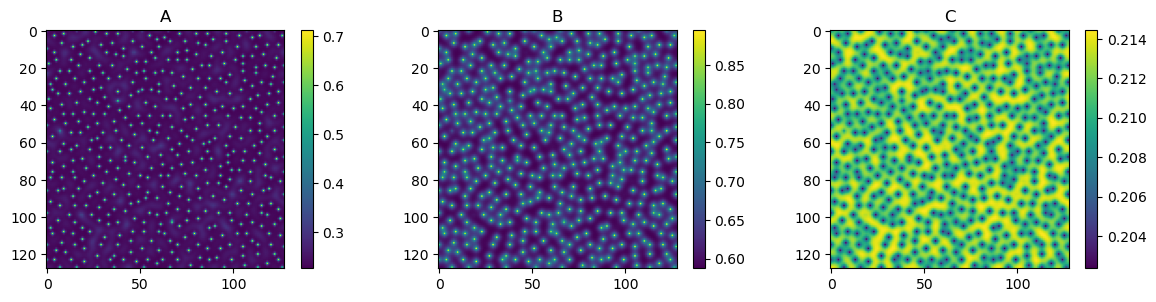

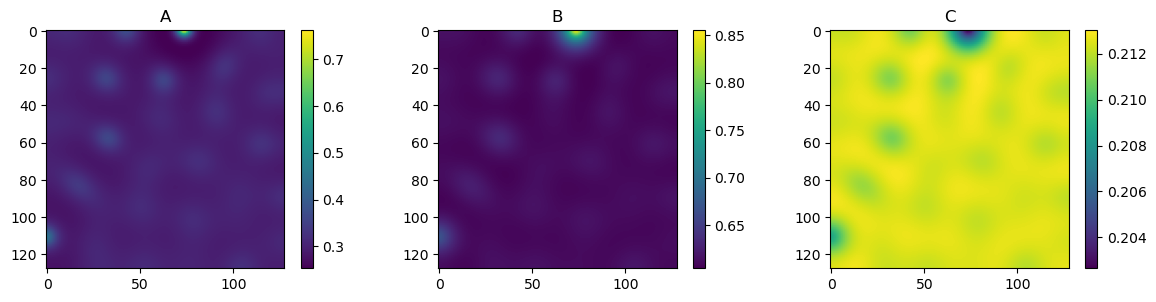

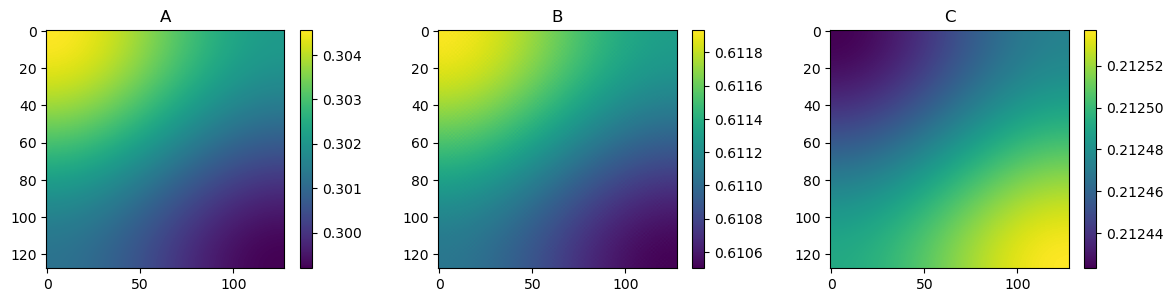

In [5]:
index = 10#2
print(indices[index])
(params, res_128_50, res_128_10, res_128_1) = load_dataset(indices[index])

def to(arr):
    return arr.reshape(128, 128) 

def reshape(arr, steps=1):
    T = arr.shape[0]
    ret = np.array([
        [to(arr[i, 0, :]), to(arr[i, 1, :]), to(arr[i, 2, :])]
        for i in range(T-steps, T)
    ])
    return np.einsum("tcxy -> cxyt", ret)


plot_n_im([to(res_128_50[-1, 0, :]), to(res_128_50[-1, 1, :]), to(res_128_50[-1, 2, :])], 
          ["A", "B", "C"],          
          figsize=(12, 3)); plt.tight_layout();plt.show()
plot_n_im([to(res_128_10[-1, 0, :]), to(res_128_10[-1, 1, :]), to(res_128_10[-1, 2, :])], 
          ["A", "B", "C"],          
          figsize=(12, 3)); plt.tight_layout();plt.show()
plot_n_im([to(res_128_1[-1, 0, :]), to(res_128_1[-1, 1, :]), to(res_128_1[-1, 2, :])], 
          ["A", "B", "C"],          
          figsize=(12, 3)); plt.tight_layout();plt.show()

In [6]:
T=1
L=50
if L == 50:
    res = res_128_50
elif L == 10:
    res = res_128_10
elif L == 1:
    res = res_128_1

data = reshape(res, T)#res_128_1[:, :, :, np.newaxis]
nodes_n = data.shape[0]
node_names = ["A", "B", "C"]
x_size = data.shape[1]
y_size = data.shape[2]
dxdy = L**2/((x_size-1)*(y_size-1))
N = x_size*y_size    
t_star = np.arange(T, T+1)

##########################
# select a subset of data
#t_star = t_star[-4:]
#T = len(t_star)
#data = data[:, :, :, -4::]


x_slice = slice(45, 100, 1)
y_slice = slice(45, 100, 1)

x_range = L * np.linspace(0, 1, x_size)[x_slice]
y_range = L * np.linspace(0, 1, y_size)[y_slice]

block_x = x_range.shape[0]
block_y = y_range.shape[0]

x = tf.constant(x_range, dtype=tf.float32)
y = tf.constant(y_range, dtype=tf.float32)


# The order of the Y and X must be reversed,
# since the chnages the value finds the derivatives
#Y, X = tf.meshgrid(x, y)

X, Y = tf.meshgrid(x, y)
ts = tf.constant(t_star, dtype=tf.float32)
T = ts[tf.newaxis, tf.newaxis, :] * tf.ones(X.shape)[:, :, tf.newaxis]
def H_cube(X, Y, T):
    return tf.concat(
            [
                tf.concat(
                    [
                        X[tf.newaxis, :, :, tf.newaxis],
                        Y[tf.newaxis, :, :, tf.newaxis],
                        T[:, :, i : i + 1][tf.newaxis, :, :, :],
                    ],
                    axis=3,
                )
                for i in range(T.shape[-1])
            ],
            axis=0,
        )
H = H_cube(X, Y, T)

#      Periodic boundary condition
X_R = tf.concat([X[:, 1:] ,  X[:, 0:1]], axis=1)
X_L = tf.concat([X[:, -1:], X[:, :-1]], axis=1)
Y_D = tf.concat([Y[1:, :] ,  Y[0:1, :]], axis=0)
Y_U = tf.concat([ Y[1:, :], Y[0:1, :]], axis=0)


    
H_R = H_cube(X_R, Y, T)
H_L = H_cube(X_L, Y, T)
H_D = H_cube(X, Y_D, T)
H_U = H_cube(X, Y_U, T)


maxs = np.array([np.max(data[i, :, :, :]) for i in range(data.shape[0])])
mins = np.array([np.min(data[i, :, :, :]) for i in range(data.shape[0])])

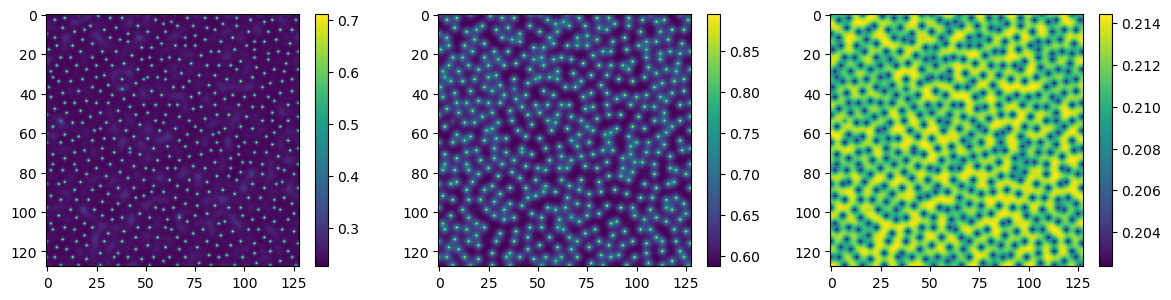

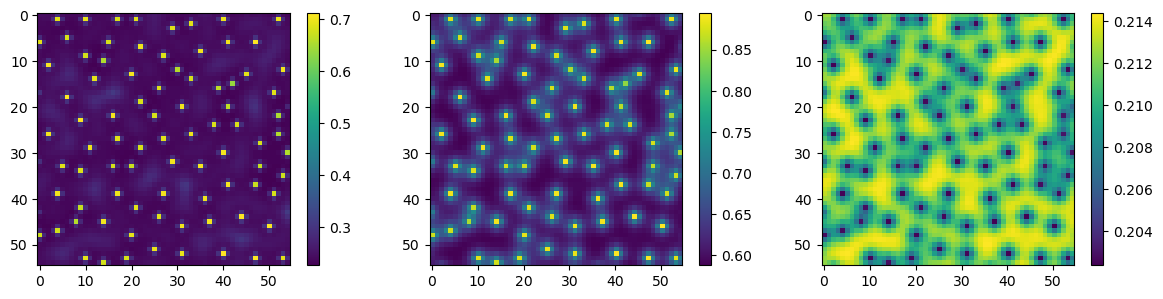

In [7]:
plt.figure(figsize=(12, 3))
for i in range(3):
    plt.subplot(1,3, i+1)
    plt.imshow(data[i, :, :, -1])
    plt.colorbar()
plt.tight_layout();plt.show()
plt.figure(figsize=(12, 3))
for i in range(3):
    plt.subplot(1,3, i+1)
    plt.imshow(data[i, x_slice, y_slice, -1])
    plt.colorbar()
plt.tight_layout();plt.show()

In [8]:
c = data[:, x_slice, y_slice, :].copy()
def gen_series():    
    
    for i in range(H.shape[0]):        
        yield H[i, ...], np.einsum( "cxy -> xyc", c[..., i]) 
        
ds = tf.data.Dataset.from_generator(gen_series,
                                    output_types=(tf.float32, tf.float32), 
                                    output_shapes=((H.shape[1],H.shape[2], H.shape[3]),
                                                   (c.shape[1],c.shape[2], c.shape[0])))

>
>
>  First
>
<h3><center>$
     \frac{\partial A}{\partial t} = b_A  +   V_A  \frac{1}{1+\left(\frac{K_{AA}}{A }\right)^{n}} \frac{1}{1+\left(\frac{B}{K_{BA} }\right)^{n}} -  \mu_A A + D_A \nabla^2 A,
$</center></h3>
to
<h3><center>$
     \frac{\partial A}{\partial t} = b_A  +   V_A  \frac{1}{ 1+ \left(\frac{K_{AA}}{A }\right)^{n} + \left(\frac{B}{K_{BA} }\right)^{n} + \left(\frac{K_{AA} B}{K_{BA} A}\right)^{n}} -  \mu_A A + D_A \nabla^2 A,
$</center></h3>
<h3><center>$
      = b_A  +    \frac{1}{\frac{1}{V_A} + \frac{1}{V_A} \left(\frac{K_{AA}}{A }\right)^{n} + \frac{1}{V_A} \left(\frac{B}{K_{BA}}\right)^{n} + \frac{1}{V_A} \left(\frac{K_{AA} B}{K_{BA} A}\right)^{n} } -  \mu_A A + D_A \nabla^2 A,
$</center></h3>
<h3><center>$
     = b_A  +    \frac{1}{G_A + G_{AA} \left(\frac{1}{A }\right)^{n} + G_{BA} \left(\frac{B}{1}\right)^{n} + G_{AABA} \left(\frac{ B}{  A}\right)^{n}}  -  \mu_A A + D_A \nabla^2 A,
$</center></h3>

for 
<h3><center>$
     V_A = G^{-1}_A, K_{AA} = (\frac{G_{AA}}{G_A})^{1/n}, K_{BA} = (\frac{G_{A}}{G_{BA}})^{1/n}, G_{AABA} = \frac{G_{AA} G_{BA}}{G_A}
$</center></h3>

>
>
> Second
>

<h3><center>$     \frac{\partial B}{\partial t} = b_B  +   V_B  \frac{1}{1+\left(\frac{K_{AB}}{A }\right)^{n}} \frac{1}{1+\left(\frac{C}{K_{CB} }\right)^{n}} -  \mu_B B + D_B \nabla^2 B,
$</center></h3>

to 
<h3><center>$    = b_B  +   V_B  \frac{1}{1+\left(\frac{K_{AB}}{A }\right)^{n} + \left(\frac{C}{K_{CB} }\right)^{n} + \left(\frac{K_{AB} C}{K_{CB} A}\right)^{n} }  -  \mu_B B + D_B \nabla^2 B,
$</center></h3>



<h3><center>$      = b_B  +    \frac{1}{\frac{1}{V_B}+ \frac{1}{V_B} \left(\frac{K_{AB}}{A }\right)^{n} + \frac{1}{V_B} \left(\frac{C}{ K_{CB} }\right)^{n} + \frac{1}{V_B} \left(\frac{K_{AB} C}{ K_{CB} A}\right)^{n} }  -  \mu_B B + D_B \nabla^2 B,
$</center></h3>
<h3><center>$      = b_B  +     \frac{1}{G_B+ G_{AB} \left(\frac{1}{A}\right)^{n} + G_{CB} \left(\frac{C}{1}\right)^{n} + G_{ABCB} \left(\frac{C}{A}\right)^{n} }  -  \mu_B B + D_B \nabla^2 B,
$</center></h3>

for 
<h3><center>$
     V_B = G^{-1}_B, K_{AB} = (\frac{G_{AB}}{G_B})^{1/n}, K_{CB} = (\frac{G_{B}}{G_{CB}})^{1/n}, G_{ABCB} = \frac{G_{AB} G_{CB}}{G_B}
$</center></h3>

>
>
> Third
>
<h3><center>$
\frac{\partial C}{\partial t} = b_C  +   V_C  \frac{1}{1+\left(\frac{A}{K_{AC} }\right)^{n}} \frac{1}{1+\left(\frac{B}{K_{BC} }\right)^{n}} \frac{1}{1+\left(\frac{K_{CC}}{C }\right)^{n}} -  \mu_C C,
$</center></h3>

to 
<h3><center>$
 = b_C  +   V_C  \frac{1}{1+\left(\frac{A}{K_{AC} }\right)^{n} + \left(\frac{B}{K_{BC} }\right)^{n} + \left(\frac{K_{CC}}{C }\right)^{n} + \left(\frac{AB}{K_{AC} K_{BC}}\right)^{n} + \left(\frac{K_{CC} A}{K_{AC} C }\right)^{n} + \left(\frac{K_{CC} B}{K_{BC} C }\right)^{n} + \left(\frac{K_{CC} AB}{K_{AC} K_{BC} C }\right)^{n}}  -  \mu_C C,
$</center></h3>
<h3><center>$
 = b_C  + \frac{1}{\frac{1}{V_C}+\frac{1}{V_C} \left(\frac{A}{K_{AC} }\right)^{n} +\frac{1}{V_C} \left(\frac{ B }{K_{BC} }\right)^{n} +\frac{1}{V_C} \left(\frac{K_{CC}}{C }\right)^{n} +\frac{1}{V_C} \left(\frac{AB}{K_{AC} K_{BC} }\right)^{n} + \frac{1}{V_C} \left(\frac{K_{CC} A}{K_{AC} C }\right)^{n} + \frac{1}{V_C} \left(\frac{K_{CC} B}{K_{BC} C }\right)^{n} + \frac{1}{V_C} \left(\frac{K_{CC} AB}{K_{AC} K_{BC} C }\right)^{n}} -  \mu_C C,
$</center></h3>


<h3><center>$
= b_C  + \frac{1}{G_C+ G_{AC} \left(\frac{A}{1}\right)^{n} + G_{BC} \left(\frac{ B }{1}\right)^{n} +G_{CC} \left(\frac{1}{C }\right)^{n} + G_{ACBC} \left(\frac{AB}{1 }\right)^{n} +  G_{ACCC} \left(\frac{ A}{C }\right)^{n} +  G_{BCCC} \left(\frac{B}{C}\right)^{n} +  G_{ACBCCC} \left(\frac{AB}{C}\right)^{n}} -  \mu_C C,
$</center></h3>

for

<h3><center>$
      V_C = G^{-1}_C, K_{AC} = (\frac{G_C}{G_{AC}})^{1/n}, K_{BC} = (\frac{G_C}{G_{BC}})^{1/n}, K_{CC} = (\frac{G_{CC}}{G_{C}})^{1/n}, K_{CC} = (\frac{G_{AB}}{G_B})^{1/n}, 
$</center></h3>
<h3><center>$
      G_{ACBC} = \frac{G_{AC} G_{BC}}{G_C}, G_{ACCC} = \frac{G_{AC} G_{CC}}{G_C}, G_{BCCC} = \frac{G_{BC} G_{CC}}{G_C}, G_{ACBCCC} = \frac{G_{AC} G_{BC} G_{CC}}{G_C G_C} 
$</center></h3>

In [11]:
params["G_A"] = 1/params["V_A"]
params["G_AA"] = np.power(params["K_AA"], params["n"])/params["V_A"]
params["G_BA"] = 1/(np.power(params["K_BA"], params["n"]))/params["V_A"]
params["G_B"] = 1/params["V_B"]
params["G_AB"] = np.power(params["K_AB"], params["n"])/params["V_B"]
params["G_CB"] = 1/(np.power(params["K_CB"], params["n"]))/params["V_B"]
params["G_C"] = 1/params["V_C"]
params["G_AC"] = 1/(np.power(params["K_AC"], params["n"]))/params["V_C"]
params["G_BC"] = 1/(np.power(params["K_BC"], params["n"]))/params["V_C"]
params["G_CC"] = np.power(params["K_CC"], params["n"])/params["V_C"]

In [32]:
def clip_by_value_zero_lb(z):
        return tf.clip_by_value(z, 0, 1e10,)
    
class tf_param:
    def __init__(self, name, value=None, is_constant=True):
        self.name = name
        if value is None:
            self.value = params[name]
        else:
            self.value = value
        self.is_constant = is_constant    
    

def create_pinn(layers=[3, 512, 512, 3],
                learning_rate=1e-2,
                w1=1, w2=1, w3=1, w4=1, w5=1,
                w6=10, w7=10, w8=10, w9=10, w10=10, w11=10,
                D_A_val=tf_param("D_A"), D_B_val=tf_param("D_B"),
                b_A_val=tf_param("b_A"),b_B_val=tf_param("b_B"),b_C_val=tf_param("b_C"),
                G_A_val=tf_param("G_A"),G_B_val=tf_param("G_B"),G_C_val=tf_param("G_C"),
                mu_A_val=tf_param("mu_A"),mu_B_val=tf_param("mu_B"),mu_C_val=tf_param("mu_C"),
                G_AA_val=tf_param("G_AA"),G_BA_val=tf_param("G_BA"),
                G_AB_val=tf_param("G_AB"),G_CB_val=tf_param("G_CB"),
                G_AC_val=tf_param("G_AC"),G_BC_val=tf_param("G_BC"),G_CC_val=tf_param("G_CC"),
                n_val=tf_param("n")): 
    # Since there is just one time step, the lower bound is zero and the upper bound is one
    lb = tf.constant([x_range[0], y_range[0], 0], dtype=tf.float32)
    ub =  tf.constant([x_range[-1], y_range[-1], t_star[0]], dtype=tf.float32)
    pinn = tu.NN_Scaled(layers, lb, ub, tf.float32)
    #optimizer=keras.optimizers.Adam(learning_rate=1e-2)   
    optimizer=keras.optimizers.Adam(learning_rate=learning_rate)
    
    def create_tf_var(param, no_clip=False):
        print(f"{param.name}: {param.value}")
        if no_clip:
            return tf.Variable(param.value,
                               dtype=pinn.dtype,
                               name=param.name)
        else:
            return tf.Variable(param.value,
                               dtype=pinn.dtype,
                               name=param.name,
                               constraint=clip_by_value_zero_lb)
    
    D_A = create_tf_var(D_A_val)    
    D_B = create_tf_var(D_B_val)
    b_A = create_tf_var(b_A_val)#
    b_B = create_tf_var(b_B_val)#
    b_C = create_tf_var(b_C_val)#
    G_A = create_tf_var(G_A_val)
    G_B = create_tf_var(G_B_val)
    G_C = create_tf_var(G_C_val)
    mu_A = create_tf_var(mu_A_val)
    mu_B = create_tf_var(mu_B_val)
    mu_C = create_tf_var(mu_C_val)
    G_AA = create_tf_var(G_AA_val)
    G_AB = create_tf_var(G_AB_val)
    G_AC = create_tf_var(G_AC_val)
    G_BA = create_tf_var(G_BA_val)
    G_BC = create_tf_var(G_BC_val)
    G_CB = create_tf_var(G_CB_val)
    G_CC = create_tf_var(G_CC_val)
    n = create_tf_var(n_val)
    
    
    G_AABA = tf.Variable(1.0,
                         dtype=pinn.dtype,
                         name="G_AABA")
    G_ABCB = tf.Variable(1.0,
                         dtype=pinn.dtype,
                         name="G_ABCB")
    G_ACBC = tf.Variable(1.0,
                         dtype=pinn.dtype,
                         name="G_ACBC")
    G_ACCC = tf.Variable(1.0,
                         dtype=pinn.dtype,
                         name="G_ACCC")
    G_BCCC = tf.Variable(1.0,
                         dtype=pinn.dtype,
                         name="G_BCCC")
    G_ACBCCC = tf.Variable(1.0,
                           dtype=pinn.dtype,
                           name="G_ACBCCC")
    
                    
    w1 = tf.Variable(w1,dtype=pinn.dtype,name="w1")
    w2 = tf.Variable(w2,dtype=pinn.dtype,name="w2")
    w3 = tf.Variable(w3,dtype=pinn.dtype,name="w3")
    w4 = tf.Variable(w4,dtype=pinn.dtype,name="w4")
    w5 = tf.Variable(w5,dtype=pinn.dtype,name="w5")
    w6 = tf.Variable(w6,dtype=pinn.dtype,name="w6")
    w7 = tf.Variable(w7,dtype=pinn.dtype,name="w7")
    w8 = tf.Variable(w8,dtype=pinn.dtype,name="w8")
    w9 = tf.Variable(w9,dtype=pinn.dtype,name="w9")
    w10 = tf.Variable(w10,dtype=pinn.dtype,name="w10")
    w11 = tf.Variable(w11,dtype=pinn.dtype,name="w11")    
                        
    def as_tuple(val, param):
        if val.is_constant:
            return ()
        else:
            return (param,)
    
    
    params_trainable =(
                      as_tuple(D_A_val, D_A)
                    + as_tuple(D_B_val, D_B)
                    + as_tuple(b_A_val, b_A)
                    + as_tuple(b_B_val, b_B)
                    + as_tuple(b_C_val, b_C)
                    + as_tuple(G_A_val, G_A)
                    + as_tuple(G_B_val, G_B)
                    + as_tuple(G_C_val, G_C)
                    + as_tuple(mu_A_val, mu_A)
                    + as_tuple(mu_B_val, mu_B)
                    + as_tuple(mu_C_val, mu_C)                    
                    + as_tuple(G_AA_val, G_AA)
                    + as_tuple(G_AB_val, G_AB)
                    + as_tuple(G_AC_val, G_AC)
                    + as_tuple(G_BA_val, G_BA)
                    + as_tuple(G_BC_val, G_BC)
                    + as_tuple(G_CB_val, G_CB)
                    + as_tuple(G_CC_val, G_CC)
                    + (G_AABA, G_ABCB, G_ACBC, G_ACCC, G_BCCC, G_ACBCCC)
                   )
    globals()["index"]=0

    @tf.function
    def train_step_inverse(elements):
        def flatten(arr):
            return tf.reshape(arr, (arr.shape[0]*arr.shape[1]*arr.shape[2], arr.shape[3]))
        
        # Using VALID padding removes the boundaries
        #print(elements[1][..., 0:1].shape)
        act_A_laplacian = pinn.derivative_fields(elements[1][..., 0:1], padding="VALID")
        #print(act_A_laplacian.shape)
        act_A_laplacian = flatten(act_A_laplacian)
        #print(act_A_laplacian.shape)
        act_B_laplacian = pinn.derivative_fields(elements[1][..., 1:2], padding="VALID") 
        act_B_laplacian = flatten(act_B_laplacian)

        act_A_rhs = tf.squeeze(D_A*act_A_laplacian/(dxdy))
        act_B_rhs = tf.squeeze(D_B*act_B_laplacian/(dxdy))
        
        def to(arr):            
            return arr.numpy().reshape(53, 53)

        
        with tf.GradientTape(persistent=True) as tape: 
            H = elements[0]
            # remove the boundaries
            H = H[:, 1:-1, 1:-1, :]
            H = flatten(H)
            tape.watch(H)
            trainables = pinn.trainable_variables + params_trainable

            outputs = pinn.net(H)
            Ag = tf.squeeze(outputs[:, 0])
            Bg = tf.squeeze(outputs[:, 1])

            grad_A = tape.gradient(Ag, H)
            A_x = grad_A[:, 0]
            A_y = grad_A[:, 1]

            grad_B = tape.gradient(Bg, H)
            B_x = grad_B[:, 0]
            B_y = grad_B[:, 1]


            grad_A_x = tape.gradient(A_x, H)
            A_xx = grad_A_x[:, 0]
            grad_A_y = tape.gradient(A_y, H)
            A_yy = grad_A_y[:, 1]
            grad_B_x = tape.gradient(B_x, H)
            B_xx = grad_B_x[:, 0]
            grad_B_y = tape.gradient(B_y, H)
            B_yy = grad_B_y[:, 1]

            H2 = elements[1]
            # remove the boundaries
            H2 = H2[:, 1:-1, 1:-1, :]
            H2 = flatten(H2)
            
            A = tf.squeeze(H2[:, 0])
            B = tf.squeeze(H2[:, 1])
            C = tf.squeeze(H2[:, 2]) 
            
            A_n = A**n
            B_n = B**n
            C_n = C**n
            
            
            A_nB_n = A_n*B_n

            def act(x, km, n=2):
                return 1 / (1 + (km / (x + 1e-20)) ** (n))
                        
            def inh(x, km, n=2):
                return 1 / (1 + (x / (km + 1e-20)) ** (n))
            
            A_rhs = D_A * (A_xx + A_yy)# - u_t
            B_rhs = D_B * (B_xx + B_yy)# - v_t
            

            #f_A =  b_A + act2(A, G_A, G_AA, n)*inh(B, K_BA, n) - mu_A * A + A_rhs
            #f_B =  b_B + act2(A, G_B, G_AB, n)*inh(C, K_CB, n) - mu_B * B + B_rhs
            #f_C =  b_C + inh(A, K_AC, n)*inh(B, K_BC, n)*act2(C, G_C, G_CC, n) - mu_C * C
            f_A =  (b_A  - mu_A * A + A_rhs 
                    + 1.0/(G_A + G_AA/A_n + G_BA*B_n + G_AABA*(B_n/(A_n+1e-30)) )
                   )
            f_B =  (b_B  - mu_B * B + B_rhs 
                    + 1.0/(G_B + G_AB/A_n + G_CB*C_n + G_ABCB*(C_n/(A_n+1e-30)) )
                   )
            f_C =  (b_C  - mu_C * C  
                    + 1.0/(G_C +  G_AC*A_n +  G_BC*B_n + G_CC/(C_n+1e-30)
                               + G_ACBC*(A_nB_n)
                               + G_ACCC*(A_n/(C_n+1e-30))
                               + G_BCCC*(B_n/(C_n+1e-30))
                               + G_ACBCCC*(A_nB_n/(C_n+1e-30))
                          )
                   )
            
            l2_res_A = tf.reduce_sum(f_A**2)
            l2_res_B = tf.reduce_sum(f_B**2)
            l2_res_C = tf.reduce_sum(f_C**2)            

            l2_res_A_rhs = tf.reduce_sum((A_rhs-act_A_rhs)**2)
            l2_res_B_rhs = tf.reduce_sum((B_rhs-act_B_rhs)**2)
            
            l2_p1 = (G_AABA - (G_AA*G_BA)/G_A)**2
            l2_p2 = (G_ABCB - (G_AB*G_CB)/G_B)**2
            l2_p3 = (G_ACBC - (G_AC*G_BC)/G_C)**2
            l2_p4 = (G_ACCC - (G_AC*G_CC)/G_C)**2
            l2_p5 = (G_BCCC - (G_BC*G_CC)/G_C)**2
            l2_p6 = (G_ACBCCC - (G_AC*G_BC*G_CC)/(G_C*G_C))**2


            l2 = (w1*l2_res_A + w2*l2_res_B + 
                  w3*l2_res_C +
                  w4*l2_res_A_rhs + w5*l2_res_B_rhs +
                  w6*l2_p1 + w7*l2_p2 + w8*l2_p3 + w9*l2_p4 + w10*l2_p5 + w11*l2_p6)
        

        grads = tape.gradient(l2, trainables)
        optimizer.apply_gradients(zip(grads, trainables))
        return (l2_res_A, l2_res_B, 
                l2_res_C,  
                l2_res_A_rhs, l2_res_B_rhs,
                l2_p1,l2_p2,l2_p3,l2_p4,l2_p5,l2_p6
        )
    
    names = ['l2_res_A', 'l2_res_B', 'l2_res_C',  
            'l2_res_A_rhs', 'l2_res_B_rhs',
            'l2 G_AABA','l2 G_ABCB','l2 G_ACBC','l2 G_ACCC','l2 G_BCCC','l2 G_ACBCCC6']

    def print_callback(printer, losses, epoch):

        printer(f"at epoch {epoch:d}, total loss: {np.sum(losses)}")
        printer(", ".join([f"{n}: {v:.8f}" for n,v in zip(names, losses)]))         
        printer(", ".join([f"{par.name}: {par.numpy()}" for par in params_trainable]))
        printer(f"V_A: {1/G_A.numpy()}, V_B: {1/G_B.numpy()}, V_C: {1/G_C.numpy()}")
        printer(f"K_AA: {np.power(G_AA.numpy()/G_A.numpy(), 1/n.numpy())}")
        printer(f"K_BA: {np.power(G_A.numpy()/G_BA.numpy(), 1/n.numpy())}")
        printer(f"K_AB: {np.power(G_AB.numpy()/G_B.numpy(), 1/n.numpy())}")
        printer(f"K_CB: {np.power(G_B.numpy()/G_CB.numpy(), 1/n.numpy())}")
        printer(f"K_AC: {np.power(G_C.numpy()/G_AC.numpy(), 1/n.numpy())}")        
        printer(f"K_BC: {np.power(G_C.numpy()/G_BC.numpy(), 1/n.numpy())}")        
        printer(f"K_CC: {np.power(G_CC.numpy()/G_C.numpy(), 1/n.numpy())}")
        
    
    
    return (pinn, optimizer, train_step_inverse,params_trainable, names, print_callback,
            w1, w2, w3, w4, w5, w6, w7, w8, w9, w10, w11)

<h3><center>$
     V_A = G^{-1}_A, K_{AA} = (\frac{G_{AA}}{G_A})^{1/n}, K_{BA} = (\frac{G_{A}}{G_{BA}})^{1/n}, G_{AABA} = \frac{G_{AA} G_{BA}}{G_A}
$</center></h3>

<h3><center>$
     V_B = G^{-1}_B, K_{AB} = (\frac{G_{AB}}{G_B})^{1/n}, K_{CB} = (\frac{G_{B}}{G_{CB}})^{1/n}, G_{ABCB} = \frac{G_{AB} G_{CB}}{G_B}
$</center></h3>

<h3><center>$
      V_C = G^{-1}_C, K_{AC} = (\frac{G_C}{G_{AC}})^{1/n}, K_{BC} = (\frac{G_C}{G_{BC}})^{1/n}, K_{CC} = (\frac{G_{CC}}{G_{C}})^{1/n}, 
$</center></h3>

<h3><center>$
      G_{ACBC} = \frac{G_{AC} G_{BC}}{G_C}, G_{ACCC} = \frac{G_{AC} G_{CC}}{G_C}, G_{BCCC} = \frac{G_{BC} G_{CC}}{G_C}, G_{ACBCCC} = \frac{G_{AC} G_{BC} G_{CC}}{G_C G_C} 
$</center></h3>


In [33]:
params

{'D_A': 0.01,
 'D_B': 1.0,
 'n': 4.0,
 'b_A': 0.1,
 'mu_A': 0.5,
 'V_A': 20.0,
 'K_AA': 1.0,
 'K_AB': 1.0,
 'K_AC': 1.0,
 'b_B': 0.1,
 'mu_B': 0.5,
 'V_B': 25.0,
 'K_BA': 0.5,
 'K_BC': 0.5,
 'b_C': 1.0,
 'mu_C': 5.0,
 'V_C': 100.0,
 'K_CB': 100.0,
 'K_CC': 1.0,
 'G_A': 0.05,
 'G_AA': 0.05,
 'G_BA': 0.8,
 'G_B': 0.04,
 'G_AB': 0.04,
 'G_CB': 4e-10,
 'G_C': 0.01,
 'G_AC': 0.01,
 'G_BC': 0.16,
 'G_CC': 0.01}

In [43]:
(pinn1, optimizer1, train_step_inverse1,params_trainable1,names, print_callback1,
w1, w2, w3, w4, w5, w6, w7, w8, w9, w10, w11) = create_pinn(learning_rate=1e-2,
b_A_val=tf_param("b_A", 1, False),b_B_val=tf_param("b_B", 1, False),
                                  b_C_val=tf_param("b_C", 10, False),
G_A_val=tf_param("G_A", 1, False),G_B_val=tf_param("G_B", 1, False),
                                  G_C_val=tf_param("G_C", 1, False),
G_AA_val=tf_param("G_AA", 1, False),
G_BA_val=tf_param("G_BA", 10, False),
G_AB_val=tf_param("G_AB", 1, False),
G_CB_val=tf_param("G_CB", 1, False),
G_AC_val=tf_param("G_AC", 1, False),
G_BC_val=tf_param("G_BC", 5, False),                                                            
G_CC_val=tf_param("G_CC", 1, False),                                   
#mu_A_val=tf_param("mu_A", 1, False),mu_B_val=tf_param("mu_B", 1, False),mu_C_val=tf_param("mu_C", 1, False),
w1=1, w2=1, w3=1, w4=100, w5=100,
w6=10, w7=10, w8=10, w9=10, w10=10, w11=10,
)

#(b_A, b_B, b_C, V_A, V_B, V_C, mu_A, mu_B, mu_C) = params_trainable1
#(b_A, b_B, b_C, V_A, V_B, V_C) = params_trainable1
#(b_A, b_B, b_C, V_C) = params_trainable1
#(b_C, V_C) = params_trainable1

D_A: 0.01
D_B: 1.0
b_A: 1
b_B: 1
b_C: 10
G_A: 1
G_B: 1
G_C: 1
mu_A: 0.5
mu_B: 0.5
mu_C: 5.0
G_AA: 1
G_AB: 1
G_AC: 1
G_BA: 10
G_BC: 5
G_CB: 1
G_CC: 1
n: 4.0


In [44]:
epochs=10000+1
params_est = np.zeros((epochs, len(params_trainable1)))

def epoch_callback1(epoch, loss_samples, index):
    params_est[epoch, : ] = [item.numpy() for item in params_trainable1]
    
epochs2=30000+1
params_est2 = np.zeros((epochs2, len(params_trainable1)))

def epoch_callback2(epoch, loss_samples, index):
    params_est2[epoch, : ] = [item.numpy() for item in params_trainable1]
    
epochs3=30000+1
params_est3 = np.zeros((epochs3, len(params_trainable1)))

def epoch_callback3(epoch, loss_samples, index):
    params_est3[epoch, : ] = [item.numpy() for item in params_trainable1]

In [45]:
losses1 = tu.train(epochs=epochs,
                  batch_size=55*55,#1225,
                  dataset = ds ,
                  train_step = train_step_inverse1,
                  train_step_returns_num = 11,
                  print_interval=1000,
                  loss_sample_interval = 1,
                  stop_threshold=1e-10,
                  print_callback = print_callback1,
                  epoch_callback=epoch_callback1,
                  stop_condition=None)
optimizer1.lr.assign(1e-3)
losses2 = tu.train(epochs=epochs2,
                  batch_size=55*55,#1225,
                  dataset = ds ,
                  train_step = train_step_inverse1,
                  train_step_returns_num = 11,
                  print_interval=1000,
                  loss_sample_interval = 1,
                  stop_threshold=1e-10,
                  print_callback = print_callback1,
                  epoch_callback=epoch_callback2,
                  stop_condition=None)
optimizer1.lr.assign(1e-4)
losses3 = tu.train(epochs=epochs3,
                  batch_size=55*55,#1225,
                  dataset = ds ,
                  train_step = train_step_inverse1,
                  train_step_returns_num = 11,
                  print_interval=1000,
                  loss_sample_interval = 1,
                  stop_threshold=1e-10,
                  print_callback = print_callback1,
                  epoch_callback=epoch_callback3,
                  stop_condition=None)


Start of epoch 0
at epoch 0, total loss: 229991.00476640463
l2_res_A: 2148.28515625, l2_res_B: 1329.32739258, l2_res_C: 224867.98437500, l2_res_A_rhs: 0.96741289, l2_res_B_rhs: 1515.44042969, l2 G_AABA: 81.00000000, l2 G_ABCB: 0.00000000, l2 G_ACBC: 16.00000000, l2 G_ACCC: 0.00000000, l2 G_BCCC: 16.00000000, l2 G_ACBCCC6: 16.00000000
b_A:0: 0.9899997711181641, b_B:0: 0.9899997711181641, b_C:0: 9.989999771118164, G_A:0: 1.010000228881836, G_B:0: 1.010000228881836, G_C:0: 1.010000228881836, G_AA:0: 0.9899997711181641, G_AB:0: 1.010000228881836, G_AC:0: 0.9899997711181641, G_BA:0: 9.989999771118164, G_BC:0: 4.989999771118164, G_CB:0: 1.009995698928833, G_CC:0: 0.9899997711181641, G_AABA:0: 1.010000228881836, G_ABCB:0: 1.0099997520446777, G_ACBC:0: 1.010000228881836, G_ACCC:0: 1.0100001096725464, G_BCCC:0: 1.010000228881836, G_ACBCCC:0: 1.010000228881836
V_A: 0.9900987855290814, V_B: 0.9900987855290814, V_C: 0.9900987855290814
K_AA: 0.9950121938340033
K_BA: 0.5638829909827743
K_AB: 1.0
K_


Start of epoch 8000
at epoch 8000, total loss: 529.9234459651713
l2_res_A: 0.17997678, l2_res_B: 246.14831543, l2_res_C: 0.44473955, l2_res_A_rhs: 0.25156102, l2_res_B_rhs: 282.89880371, l2 G_AABA: 0.00001044, l2 G_ABCB: 0.00003904, l2 G_ACBC: 0.00000000, l2 G_ACCC: 0.00000000, l2 G_BCCC: 0.00000000, l2 G_ACBCCC6: 0.00000000
b_A:0: 0.09215766191482544, b_B:0: 0.1484544426202774, b_C:0: 1.0537109375, G_A:0: 0.8197007179260254, G_B:0: 0.021018479019403458, G_C:0: 1.7173222303390503, G_AA:0: 0.09040455520153046, G_AB:0: 0.0502491220831871, G_AC:0: 0.6092081069946289, G_BA:0: 1.9370553493499756, G_BC:0: 3.8420286178588867, G_CB:0: 0.15364916622638702, G_CC:0: 1.8965060710906982, G_AABA:0: 0.2104933112859726, G_ABCB:0: 0.34928545355796814, G_ACBC:0: 1.362923502922058, G_ACCC:0: 0.6727772355079651, G_BCCC:0: 4.2429351806640625, G_ACBCCC:0: 1.5051440000534058
V_A: 1.2199574529227701, V_B: 47.577181920577516, V_C: 0.5823019013750089
K_AA: 0.5762802640697913
K_BA: 0.8065444746231609
K_AB: 1.24


Start of epoch 5000
at epoch 5000, total loss: 85.84750718744564
l2_res_A: 0.04919310, l2_res_B: 41.96863556, l2_res_C: 0.44367248, l2_res_A_rhs: 0.09862523, l2_res_B_rhs: 43.28738022, l2 G_AABA: 0.00000005, l2 G_ABCB: 0.00000056, l2 G_ACBC: 0.00000000, l2 G_ACCC: 0.00000000, l2 G_BCCC: 0.00000000, l2 G_ACBCCC6: 0.00000000
b_A:0: 0.09288782626390457, b_B:0: 0.11966980248689651, b_C:0: 1.0536260604858398, G_A:0: 1.1787022352218628, G_B:0: 0.025861136615276337, G_C:0: 1.6419817209243774, G_AA:0: 0.10819175094366074, G_AB:0: 0.0441427119076252, G_AC:0: 0.5999100804328918, G_BA:0: 1.3919577598571777, G_BC:0: 4.0137434005737305, G_CB:0: 0.20595473051071167, G_CC:0: 1.6638100147247314, G_AABA:0: 0.12813976407051086, G_ABCB:0: 0.3518241345882416, G_ACBC:0: 1.4664387702941895, G_ACCC:0: 0.6078951954841614, G_BCCC:0: 4.067145347595215, G_ACBCCC:0: 1.4859516620635986
V_A: 0.8483906877565, V_B: 38.66806068412684, V_C: 0.6090201780303836
K_AA: 0.550424186818108
K_BA: 0.9592780629208773
K_AB: 1.14


Start of epoch 13000
at epoch 13000, total loss: 42.344224301940905
l2_res_A: 0.03459168, l2_res_B: 20.91847992, l2_res_C: 0.00006532, l2_res_A_rhs: 0.08495885, l2_res_B_rhs: 21.30611992, l2 G_AABA: 0.00000815, l2 G_ABCB: 0.00000035, l2 G_ACBC: 0.00000000, l2 G_ACCC: 0.00000003, l2 G_BCCC: 0.00000005, l2 G_ACBCCC6: 0.00000001
b_A:0: 0.0929834321141243, b_B:0: 0.11017868667840958, b_C:0: 0.99935382604599, G_A:0: 1.8767539262771606, G_B:0: 0.030466141179203987, G_C:0: 0.31519249081611633, G_AA:0: 0.1223055049777031, G_AB:0: 0.04224073886871338, G_AC:0: 0.1666092872619629, G_BA:0: 0.5127742886543274, G_BC:0: 5.280869007110596, G_CB:0: 0.2424517124891281, G_CC:0: 0.008985324762761593, G_AABA:0: 0.036203399300575256, G_ABCB:0: 0.33682867884635925, G_ACBC:0: 2.7914421558380127, G_ACCC:0: 0.004930595867335796, G_BCCC:0: 0.1502731442451477, G_ACBCCC:0: 0.07965991646051407
V_A: 0.5328349049913319, V_B: 32.823323246548675, V_C: 3.1726644166259694
K_AA: 0.5052538912704225
K_BA: 1.383153161946683


Start of epoch 21000
at epoch 21000, total loss: 31.565535876596474
l2_res_A: 0.03005303, l2_res_B: 15.65385532, l2_res_C: 0.00009554, l2_res_A_rhs: 0.08099741, l2_res_B_rhs: 15.80052471, l2 G_AABA: 0.00000805, l2 G_ABCB: 0.00000021, l2 G_ACBC: 0.00000071, l2 G_ACCC: 0.00000000, l2 G_BCCC: 0.00000056, l2 G_ACBCCC6: 0.00000032
b_A:0: 0.09301640093326569, b_B:0: 0.10634873807430267, b_C:0: 0.9980584383010864, G_A:0: 2.127056837081909, G_B:0: 0.032448939979076385, G_C:0: 0.35657641291618347, G_AA:0: 0.12711375951766968, G_AB:0: 0.04133111611008644, G_AC:0: 0.19026799499988556, G_BA:0: 0.16092608869075775, G_BC:0: 5.225022315979004, G_CB:0: 0.25351256132125854, G_CC:0: 0.009693142026662827, G_AABA:0: 0.012550923973321915, G_ABCB:0: 0.3223526179790497, G_ACBC:0: 2.787003755569458, G_ACCC:0: 0.0052468441426754, G_BCCC:0: 0.14098314940929413, G_ACBCCC:0: 0.07515300065279007
V_A: 0.47013318241739666, V_B: 30.817647684171398, V_C: 2.8044479774242923
K_AA: 0.49442835097799803
K_BA: 1.9067254263


Start of epoch 29000
at epoch 29000, total loss: 18.155317750703105
l2_res_A: 0.02782774, l2_res_B: 8.99473667, l2_res_C: 0.00000948, l2_res_A_rhs: 0.07628322, l2_res_B_rhs: 9.05644798, l2 G_AABA: 0.00001263, l2 G_ABCB: 0.00000003, l2 G_ACBC: 0.00000000, l2 G_ACCC: 0.00000000, l2 G_BCCC: 0.00000000, l2 G_ACBCCC6: 0.00000000
b_A:0: 0.09316696971654892, b_B:0: 0.10531004518270493, b_C:0: 0.9979240298271179, G_A:0: 2.198843479156494, G_B:0: 0.03343774750828743, G_C:0: 0.36336272954940796, G_AA:0: 0.1278424859046936, G_AB:0: 0.04128199815750122, G_AC:0: 0.1944761425256729, G_BA:0: 0.060053497552871704, G_BC:0: 5.2121381759643555, G_CB:0: 0.2494424283504486, G_CC:0: 0.009720250964164734, G_AABA:0: 0.006829119753092527, G_ABCB:0: 0.30771392583847046, G_ACBC:0: 2.789595127105713, G_ACCC:0: 0.005218548700213432, G_BCCC:0: 0.13941898941993713, G_ACBCCC:0: 0.07464120537042618
V_A: 0.454784530813268, V_B: 29.906320685989794, V_C: 2.7520709161340275
K_AA: 0.4910437886125424
K_BA: 2.45988048271159


Start of epoch 6000
at epoch 6000, total loss: 14.362776732017766
l2_res_A: 0.02644749, l2_res_B: 7.10553932, l2_res_C: 0.00000943, l2_res_A_rhs: 0.07509924, l2_res_B_rhs: 7.15566969, l2 G_AABA: 0.00001156, l2 G_ABCB: 0.00000000, l2 G_ACBC: 0.00000000, l2 G_ACCC: 0.00000000, l2 G_BCCC: 0.00000000, l2 G_ACBCCC6: 0.00000000
b_A:0: 0.09325204789638519, b_B:0: 0.10526282340288162, b_C:0: 0.9979093670845032, G_A:0: 2.211008310317993, G_B:0: 0.033366892486810684, G_C:0: 0.3637441396713257, G_AA:0: 0.1283080279827118, G_AB:0: 0.04120180383324623, G_AC:0: 0.1949547380208969, G_BA:0: 0.03836192190647125, G_BC:0: 5.209112167358398, G_CB:0: 0.24211232364177704, G_CC:0: 0.00972833763808012, G_AABA:0: 0.005622562952339649, G_ABCB:0: 0.29895883798599243, G_ACBC:0: 2.791914224624634, G_ACCC:0: 0.005227962043136358, G_BCCC:0: 0.13931135833263397, G_ACBCCC:0: 0.07468602806329727
V_A: 0.4522823344142824, V_B: 29.96982713914044, V_C: 2.7491851852337374
K_AA: 0.4908127819790347
K_BA: 2.755322923386531
K_


Start of epoch 14000
at epoch 14000, total loss: 12.6860251867901
l2_res_A: 0.02595098, l2_res_B: 6.27549553, l2_res_C: 0.00000948, l2_res_A_rhs: 0.07461278, l2_res_B_rhs: 6.30994463, l2 G_AABA: 0.00001178, l2 G_ABCB: 0.00000000, l2 G_ACBC: 0.00000000, l2 G_ACCC: 0.00000000, l2 G_BCCC: 0.00000000, l2 G_ACBCCC6: 0.00000000
b_A:0: 0.09328236430883408, b_B:0: 0.10522908717393875, b_C:0: 0.9979066252708435, G_A:0: 2.2349982261657715, G_B:0: 0.03368834778666496, G_C:0: 0.3634931743144989, G_AA:0: 0.12873812019824982, G_AB:0: 0.04114467650651932, G_AC:0: 0.19535711407661438, G_BA:0: 0.0037093115970492363, G_BC:0: 5.204006671905518, G_CB:0: 0.2322852909564972, G_CC:0: 0.009733235463500023, G_AABA:0: 0.0036446661688387394, G_ABCB:0: 0.2836858928203583, G_ACBC:0: 2.7968108654022217, G_ACCC:0: 0.005244955886155367, G_BCCC:0: 0.13930875062942505, G_ACBCCC:0: 0.07488398253917694
V_A: 0.4474276481711307, V_B: 29.6838540830974, V_C: 2.751083295816684
K_AA: 0.48990006136198155
K_BA: 4.95445582961725


Start of epoch 22000
at epoch 22000, total loss: 11.864092875656151
l2_res_A: 0.02536953, l2_res_B: 5.87198973, l2_res_C: 0.00000930, l2_res_A_rhs: 0.07440300, l2_res_B_rhs: 5.89230967, l2 G_AABA: 0.00001165, l2 G_ABCB: 0.00000000, l2 G_ACBC: 0.00000000, l2 G_ACCC: 0.00000000, l2 G_BCCC: 0.00000000, l2 G_ACBCCC6: 0.00000000
b_A:0: 0.09326948970556259, b_B:0: 0.1049540787935257, b_C:0: 0.9979149699211121, G_A:0: 2.237346649169922, G_B:0: 0.03414521738886833, G_C:0: 0.36301085352897644, G_AA:0: 0.12873442471027374, G_AB:0: 0.041055116802453995, G_AC:0: 0.19561785459518433, G_BA:0: 0.0, G_BC:0: 5.199244976043701, G_CB:0: 0.223403662443161, G_CC:0: 0.009730596095323563, G_AABA:0: 0.0034010163508355618, G_ABCB:0: 0.26863420009613037, G_ACBC:0: 2.801736354827881, G_ACCC:0: 0.005256349686533213, G_BCCC:0: 0.13935235142707825, G_ACBCCC:0: 0.07511010766029358
V_A: 0.44695800732131075, V_B: 29.286678383427414, V_C: 2.7547385712537036
K_AA: 0.4897679418113667
K_BA: inf
K_AB: 1.0471511023165734
K


Start of epoch 30000
at epoch 30000, total loss: 10.871769133528515
l2_res_A: 0.02514500, l2_res_B: 5.37196207, l2_res_C: 0.00000948, l2_res_A_rhs: 0.07417949, l2_res_B_rhs: 5.40046120, l2 G_AABA: 0.00001189, l2 G_ABCB: 0.00000000, l2 G_ACBC: 0.00000001, l2 G_ACCC: 0.00000000, l2 G_BCCC: 0.00000000, l2 G_ACBCCC6: 0.00000000
b_A:0: 0.09325165301561356, b_B:0: 0.10475996881723404, b_C:0: 0.9979203939437866, G_A:0: 2.2372798919677734, G_B:0: 0.03442447632551193, G_C:0: 0.36249271035194397, G_AA:0: 0.128704234957695, G_AB:0: 0.04097054526209831, G_AC:0: 0.19586248695850372, G_BA:0: 0.0, G_BC:0: 5.194530963897705, G_CB:0: 0.21283018589019775, G_CC:0: 0.009731563739478588, G_AABA:0: 0.0034465750213712454, G_ABCB:0: 0.25328701734542847, G_ACBC:0: 2.8066508769989014, G_ACCC:0: 0.005272050853818655, G_BCCC:0: 0.13940733671188354, G_ACBCCC:0: 0.07533618062734604
V_A: 0.4469713439030025, V_B: 29.04909839569299, V_C: 2.758676164905773
K_AA: 0.48974288147504685
K_BA: inf
K_AB: 1.0444823404104058
K

In [ ]:
'b_A': 0.1, 'b_B': 0.1, 'b_C': 1.0 
'V_A': 20.0, 'V_B': 25.0, 'V_C': 100.0
'K_AA': 1.0, 
'K_BA': 0.5, 
'K_AB': 1.0, 
'K_CB': 100.0, 
'K_AC': 1.0,         
'K_BC': 0.5, 
'K_CC': 1.0     

In [25]:
losses1 = tu.train(epochs=epochs,
                  batch_size=55*55,#1225,
                  dataset = ds ,
                  train_step = train_step_inverse1,
                  train_step_returns_num = 11,
                  print_interval=1000,
                  loss_sample_interval = 1,
                  stop_threshold=1e-10,
                  print_callback = print_callback1,
                  epoch_callback=epoch_callback1,
                  stop_condition=None)
optimizer1.lr.assign(1e-4)
losses2 = tu.train(epochs=epochs2,
                  batch_size=55*55,#1225,
                  dataset = ds ,
                  train_step = train_step_inverse1,
                  train_step_returns_num = 11,
                  print_interval=1000,
                  loss_sample_interval = 1,
                  stop_threshold=1e-10,
                  print_callback = print_callback1,
                  epoch_callback=epoch_callback2,
                  stop_condition=None)


Start of epoch 0
at epoch 0, total loss: 229990.90320372581
l2_res_A: 2148.28540039, l2_res_B: 1329.22741699, l2_res_C: 224867.98437500, l2_res_A_rhs: 0.96741271, l2_res_B_rhs: 1515.43859863, l2 G_AABA: 81.00000000, l2 G_ABCB: 0.00000000, l2 G_ACBC: 16.00000000, l2 G_ACCC: 0.00000000, l2 G_BCCC: 16.00000000, l2 G_ACBCCC6: 16.00000000
b_A:0: 0.9899997711181641, b_B:0: 0.9899997711181641, b_C:0: 9.989999771118164, G_A:0: 1.010000228881836, G_B:0: 1.010000228881836, G_C:0: 1.010000228881836, G_AA:0: 0.9899997711181641, G_AB:0: 1.010000228881836, G_AC:0: 0.9899997711181641, G_BA:0: 9.989999771118164, G_BC:0: 4.989999771118164, G_CB:0: 1.009995698928833, G_CC:0: 0.9899997711181641, G_AABA:0: 1.010000228881836, G_ABCB:0: 1.0099997520446777, G_ACBC:0: 1.010000228881836, G_ACCC:0: 1.0100001096725464, G_BCCC:0: 1.010000228881836, G_ACBCCC:0: 1.010000228881836
V_A: 0.9900987855290814, V_B: 0.9900987855290814, V_C: 0.9900987855290814
K_AA: 0.9950121938340033
K_BA: 0.5638829909827743
K_AB: 1.0
K_


Start of epoch 8000
at epoch 8000, total loss: 364.0982589241074
l2_res_A: 0.11804945, l2_res_B: 172.50077820, l2_res_C: 0.44473955, l2_res_A_rhs: 0.18168592, l2_res_B_rhs: 190.85299683, l2 G_AABA: 0.00000000, l2 G_ABCB: 0.00000897, l2 G_ACBC: 0.00000000, l2 G_ACCC: 0.00000000, l2 G_BCCC: 0.00000000, l2 G_ACBCCC6: 0.00000000
b_A:0: 0.09374477714300156, b_B:0: 0.13449501991271973, b_C:0: 1.0537109375, G_A:0: 0.7823333740234375, G_B:0: 0.0517723374068737, G_C:0: 1.7173222303390503, G_AA:0: 0.0957680493593216, G_AB:0: 0.04723909869790077, G_AC:0: 0.6092081069946289, G_BA:0: 1.8549470901489258, G_BC:0: 3.8420286178588867, G_CB:0: 0.679037868976593, G_CC:0: 1.8965060710906982, G_AABA:0: 0.2275703400373459, G_ABCB:0: 0.619140088558197, G_ACBC:0: 1.362923502922058, G_ACCC:0: 0.6727772355079651, G_BCCC:0: 4.2429351806640625, G_ACBCCC:0: 1.5051440000534058
V_A: 1.2782274580172026, V_B: 19.315334212962, V_C: 0.5823019013750089
K_AA: 0.5915033351002139
K_BA: 0.8058701684010183
K_AB: 0.9773518933


Start of epoch 5000
at epoch 5000, total loss: 104.84570412261479
l2_res_A: 0.05593849, l2_res_B: 51.13504028, l2_res_C: 0.44433883, l2_res_A_rhs: 0.10112578, l2_res_B_rhs: 53.10926056, l2 G_AABA: 0.00000018, l2 G_ABCB: 0.00000000, l2 G_ACBC: 0.00000000, l2 G_ACCC: 0.00000000, l2 G_BCCC: 0.00000000, l2 G_ACBCCC6: 0.00000000
b_A:0: 0.09275295585393906, b_B:0: 0.11545948684215546, b_C:0: 1.053680419921875, G_A:0: 0.9571501612663269, G_B:0: 0.03510235249996185, G_C:0: 1.687861680984497, G_AA:0: 0.10125146806240082, G_AB:0: 0.04161267727613449, G_AC:0: 0.6058573722839355, G_BA:0: 1.6254767179489136, G_BC:0: 3.9110069274902344, G_CB:0: 0.548214852809906, G_CC:0: 1.8022229671478271, G_AABA:0: 0.17152687907218933, G_ABCB:0: 0.6498278975486755, G_ACBC:0: 1.4038441181182861, G_ACCC:0: 0.6469126343727112, G_BCCC:0: 4.176034927368164, G_ACBCCC:0: 1.498977541923523
V_A: 1.0447681465957044, V_B: 28.488119136775428, V_C: 0.592465609751102
K_AA: 0.5703025537975391
K_BA: 0.8759913807700712
K_AB: 1.04

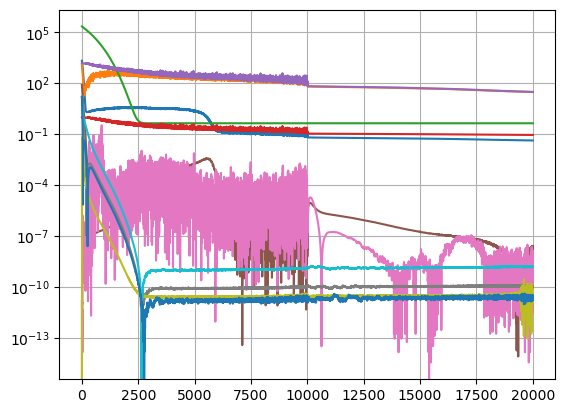

In [28]:
plt.plot(np.concatenate([losses1, losses2]))
plt.yscale('log')
plt.grid()

In [24]:
params_est_1 = params_est.copy()

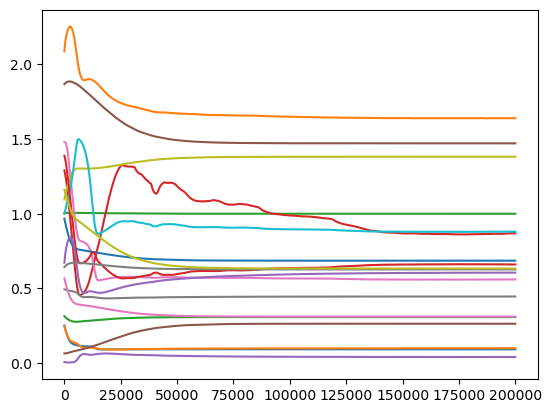

In [25]:
plt.plot(params_est_1); plt.show()

In [48]:
(b_A_val, b_B_val, b_C_val, G_A_val, G_B_val, G_C_val,
 G_AA_val, G_AB_val, G_AC_val, G_BA_val, G_BC_val, 
 G_CB_val, G_CC_val,
 G_AABA, G_ABCB, G_ACBC, G_ACCC, G_BCCC, G_ACBCCC) = params_trainable1

In [52]:
V_A_val = 1/G_A_val 
V_B_val = 1/G_B_val 
V_C_val = 1/G_C_val
K_AA_val = np.power(G_AA_val/G_A_val, 1/params["n"])
K_BA_val = np.power(G_A_val/G_BA_val, 1/params["n"])
K_AB_val = np.power(G_AB_val/G_B_val, 1/params["n"])
K_CB_val = np.power(G_B_val/G_CB_val, 1/params["n"])
K_AC_val = np.power(G_C_val/G_AC_val, 1/params["n"])
K_BC_val = np.power(G_C_val/G_BC_val, 1/params["n"])
K_CC_val = np.power(G_CC_val/G_C_val, 1/params["n"])

In [53]:
(n_val, D_A_val, D_B_val,
 b_A_val, b_B_val, b_C_val, V_A_val, V_B_val, V_C_val, mu_A_val, mu_B_val, mu_C_val,
 K_AA_val, K_AB_val, K_AC_val, K_BA_val, K_BC_val, 
 K_CB_val, K_CC_val ) = (params["n"], params["D_A"], params["D_B"],
                         b_A_val, b_B_val, b_C_val,
                         V_A_val, V_B_val, V_C_val,
                         params["mu_A"], params["mu_B"], params["mu_C"],
                         K_AA_val, K_AB_val, K_AC_val, 
                         K_BA_val, K_BC_val, 
                         K_CB_val, K_CC_val)

In [54]:
with open(f"./parameters_temp.npy", "wb") as f:
    np.save(f, (n_val, D_A_val, D_B_val,
                b_A_val, b_B_val, b_C_val, V_A_val, V_B_val, V_C_val, mu_A_val, mu_B_val, mu_C_val,
                K_AA_val, K_AB_val, K_AC_val, K_BA_val, K_BC_val, 
                K_CB_val, K_CC_val))

In [26]:
c_xx =  np.array([[second_order_derivatives((x_size,y_size), data[c, ..., t])[0]/dxdy 
                        for t in range(data.shape[3])]
                        for c in range(data.shape[0])
                       ])
c_xx = np.einsum("ctij -> cijt", c_xx)
c_yy = np.array([[second_order_derivatives((x_size,y_size), data[c, ..., t])[1]/dxdy 
                    for t in range(data.shape[3])]
                    for c in range(data.shape[0])
                   ])
c_yy = np.einsum("ctij -> cijt", c_yy)

D_A = params["D_A"]
D_B = params["D_B"]

#c_t = np.stack([f_A, f_B, f_C, f_D, f_E, f_F])[:,:,:, np.newaxis]

In [31]:
@tf.function
def grads(pinn, H):
    def flatten(arr):
        return tf.reshape(arr, (arr.shape[0]*arr.shape[1]*arr.shape[2], arr.shape[3]))
    
    with tf.GradientTape(persistent=True) as tape:
        # remove the boundaries
        H = H[:, :, :, :]
        H = flatten(H)
        tape.watch(H)
        
        outputs = pinn.net(H)
        Ag = tf.squeeze(outputs[:, 0])
        Bg = tf.squeeze(outputs[:, 1])
        #Cg = tf.squeeze(outputs[:, 2])
        

        grad_A = tape.gradient(Ag, H)
        A_x = grad_A[:, 0]
        A_y = grad_A[:, 1]
        A_t = grad_A[:, 2]

        grad_B = tape.gradient(Bg, H)
        B_x = grad_B[:, 0]
        B_y = grad_B[:, 1]
        B_t = grad_B[:, 2]


        grad_A_x = tape.gradient(A_x, H)
        A_xx = grad_A_x[:, 0]
        grad_A_y = tape.gradient(A_y, H)
        A_yy = grad_A_y[:, 1]
        grad_B_x = tape.gradient(B_x, H)
        B_xx = grad_B_x[:, 0]
        grad_B_y = tape.gradient(B_y, H)
        B_yy = grad_B_y[:, 1]
        
        
    return (tf.squeeze(Ag), tf.squeeze(A_xx), tf.squeeze(A_yy), tf.squeeze(A_t),
            tf.squeeze(Bg), tf.squeeze(B_xx), tf.squeeze(B_yy), tf.squeeze(B_t),
            #tf.squeeze(Cg)
           )                               



def plot_state(pinn):
    def to(arr):
        return arr.numpy().reshape(block_x, block_y)

    (A, A_xx, A_yy, A_t,
     B, B_xx, B_yy, B_t,
     #C, 
    ) = grads(pinn, H)

    A_der = D_A*( to(A_xx) + to(A_yy))
    B_der = D_B*( to(B_xx) + to(B_yy))

    actual_A_der = D_A*( c_xx[0,x_slice, y_slice  , -1] + c_yy[0,x_slice, y_slice  , -1])# - to(u_t2)[-1, ...]
    actual_B_der = D_B*( c_xx[1,x_slice, y_slice  , -1] + c_yy[1,x_slice, y_slice  , -1])# - to(v_t2)[-1, ...]
    # X and Y are misoriented
    #A_der = A_der
    #B_der = B_der

    plot_n_im([to(A), c[0,:, : , -1], to(B), c[1,:, :  , -1]], 
      ["A", "Actual A", "B", "Actual B"],          
      figsize=(12, 3)); plt.tight_layout()

    A = c[0,:, : , -1]
    B = c[1,:, : , -1]
    print(np.sum((A_der-actual_A_der)**2))
    print(np.sum((B_der-actual_B_der)**2))


    plot_n_im([to(A_xx), c_xx[0,x_slice, y_slice , -1], to(A_yy), c_yy[0,x_slice, y_slice  , -1]], 
      ["A_xx", "Actual A_xx", "A_yy", "Actual A_yy"],          
      figsize=(12, 3)); plt.tight_layout()

    plot_n_im([to(B_xx), c_xx[1,x_slice, y_slice  , -1], to(B_yy), c_yy[1,x_slice, y_slice  , -1]],
              ["B_xx", "Actual B_xx", "B_yy", "Actual B_yy"],          
              figsize=(12, 3)); plt.tight_layout()
   # plot_n_im([to(A_t),  c_t[0,x_slice, y_slice , -1],  to(B_t),  c_t[1,x_slice, y_slice , -1]],
    #           ["A_t", "Actual A_t", "B_t", "Actual B_t"],          
    #           figsize=(12, 3)); plt.tight_layout()
#         plot_n_im([c_t[0,x_slice, y_slice , -1],   c_t[1,x_slice, y_slice, -1]],
#                    ["Actual A_t",  "Actual B_t"],          
#                    figsize=(12, 3)); plt.tight_layout()
    plot_n_im([A_der[1:-1],  actual_A_der],
              ["RHS A", "Actual RHS A"],          
              figsize=(12, 3)); plt.tight_layout()
    plot_n_im([B_der[1:-1],  actual_B_der],
              ["RHS B", "Actual RHS B"],          
              figsize=(12, 3)); plt.tight_layout()
    plt.show()

4.142576040061757
6384.551211847305


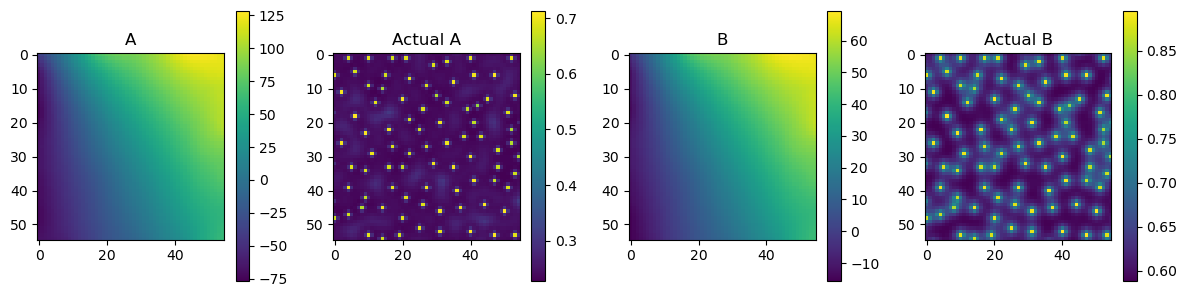

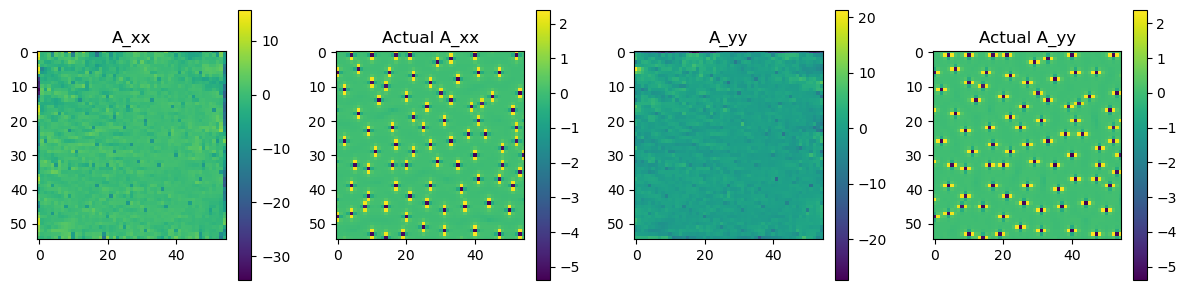

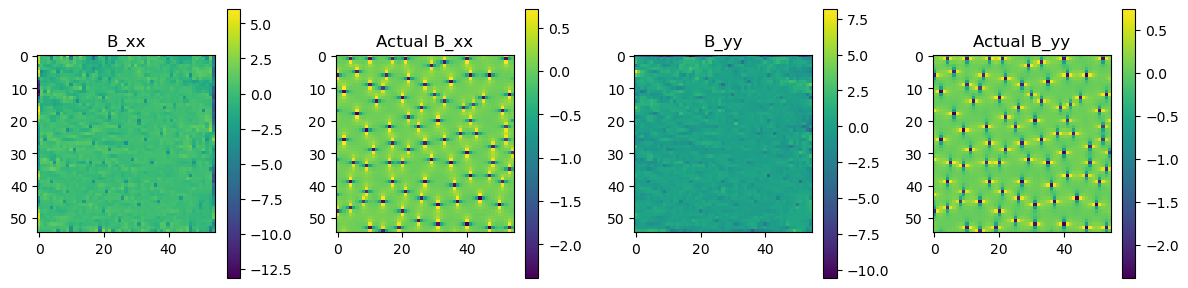

In [ ]:
plot_state(pinn1)